# Brain Tumors Object Detection using YOLOv8


> Brain tumors present a major diagnostic problem in medicine, requiring effective and precise detection methods. In this work, we use the YOLOv8 deep learning model to identify and locate brain cancers in MRI images. The dataset, which was obtained via Kaggle, includes bounding box annotations on MRI images, allowing for object detection-based classification. Our method entails pre-processing MRI scans, optimizing the YOLOv8 model, and assessing its effectiveness using common measures like recall, precision, and mAP (mean average precision). The model can detect and categorize cancers properly in real-time with high confidence scores, according to experimental results. YOLOv8 is a promising option for automated tumor screening since it provides a quicker and more reliable detection process than conventional convolutional neural networks (CNNs). The possibilities of deep learning in medical imaging are demonstrated by this study, which also opens the door for the incorporation of object detection models into clinical procedures.

# Imports & Setup

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

# Explore Classes

In [2]:
train_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_tumor_object_detection\Train"
test_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_tumor_object_detection\Val"
categories = os.listdir(train_dir)
print("Classes:", categories)

Classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


# Sample Images

Train images


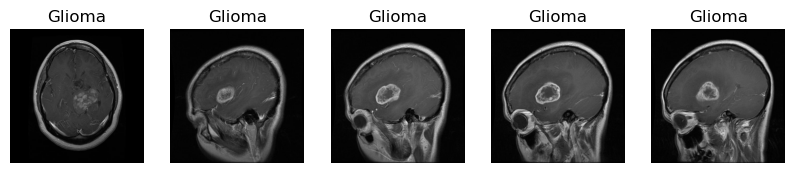

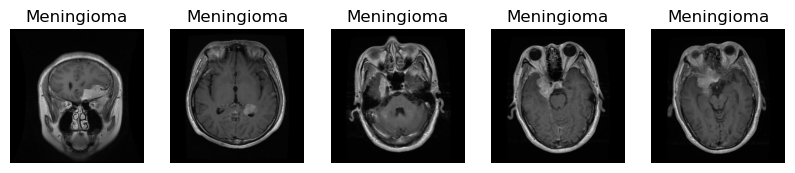

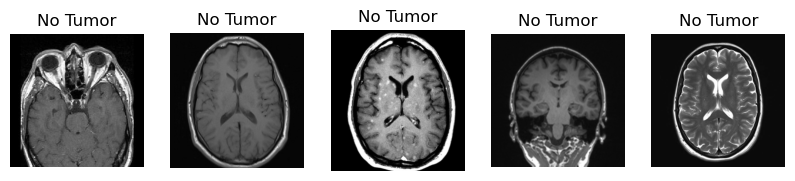

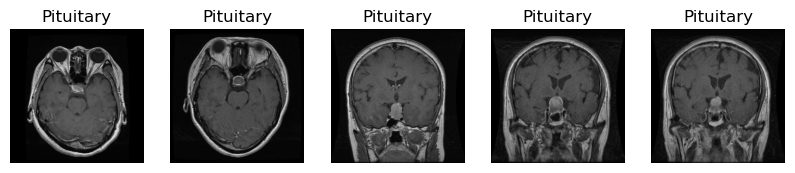

Validation Images


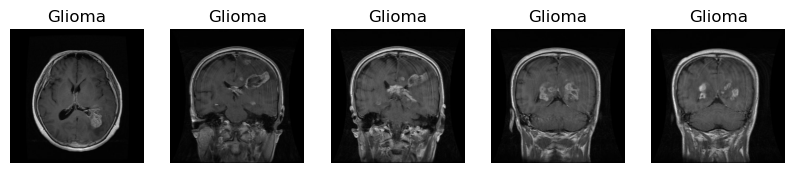

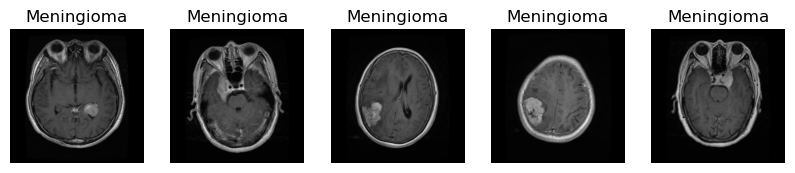

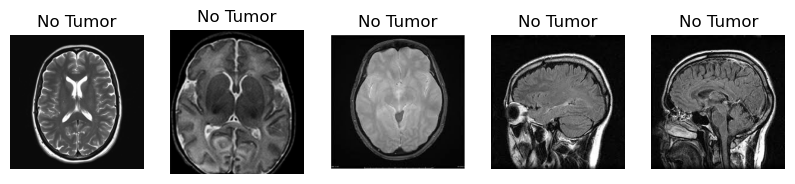

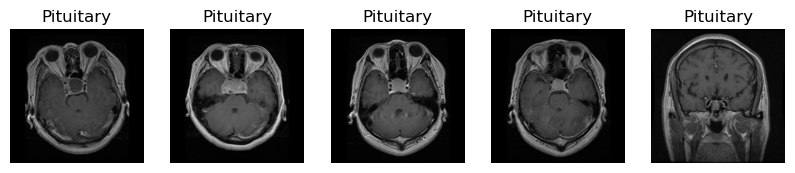

In [3]:
import os
import cv2

classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
def sample_images(folder_path, num_samples = 5):
    for i in range(0,4):
        folder_path_final = os.path.join(folder_path,classes[i],'images')
        images = os.listdir(folder_path_final)
        sample_images = images[:num_samples]
        plt.figure(figsize=(10, 10))
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(folder_path_final, img_name)
            img = cv2.imread(img_path)
            
            plt.subplot(1, num_samples, j+1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    
        plt.show()
print("Train images")
sample_images(train_dir)
print("Validation Images")
sample_images(test_dir)

c:\Users\Mahdi Mzari\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


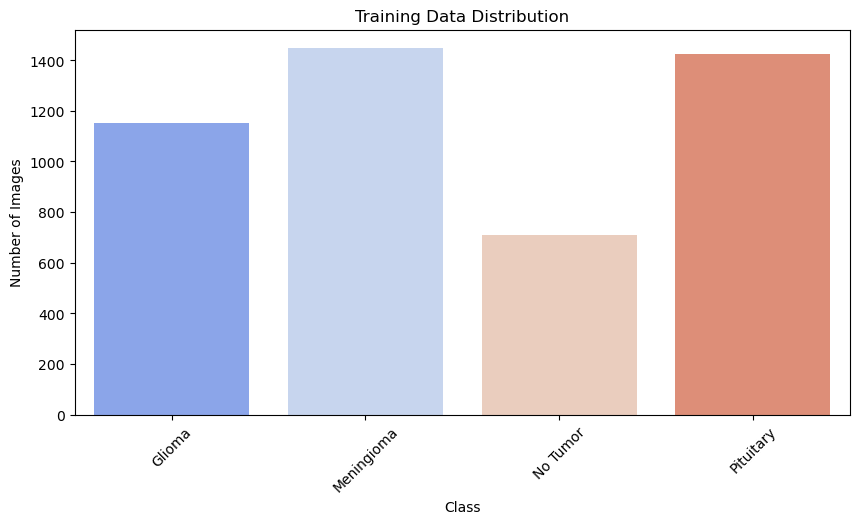

In [4]:
import seaborn as sns

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls, "images"))) for cls in categories}

# Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution")
plt.show()


# Visualize Bounding Boxes

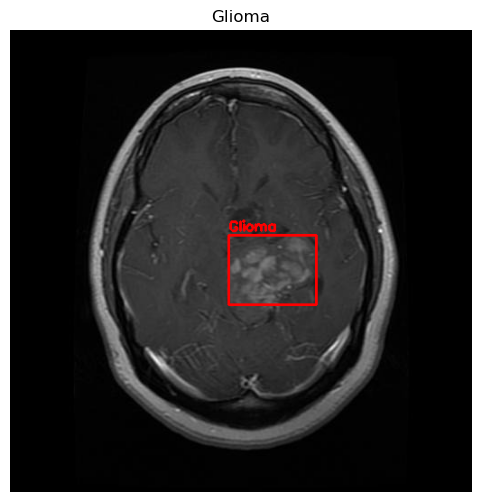

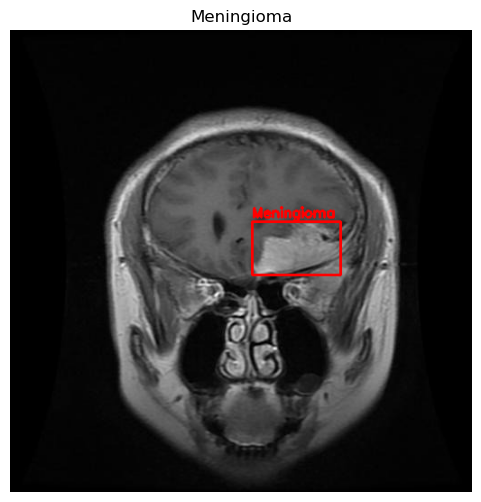

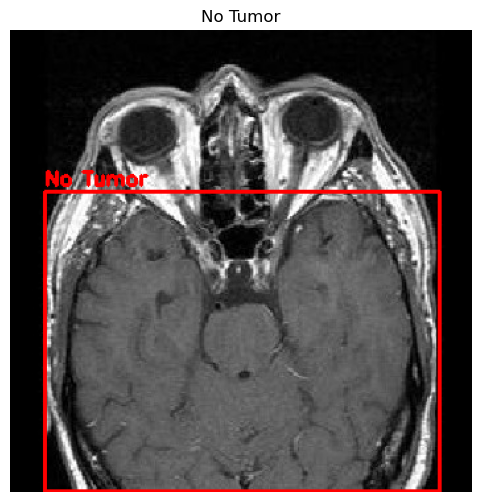

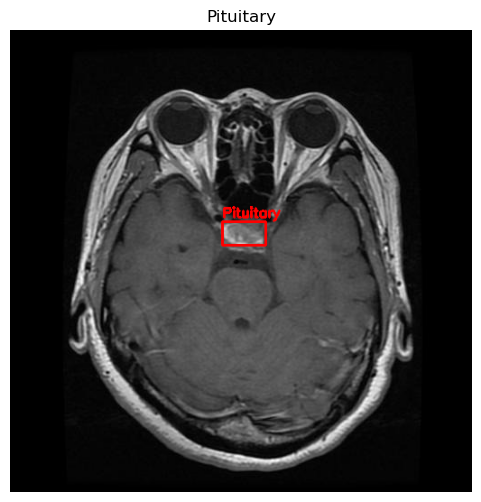

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_path = train_dir
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

def visualize_bounding_boxes(class_name, img_name):
    img_path = os.path.join(dataset_path, class_name, "images", img_name)
    label_path = os.path.join(dataset_path, class_name, "labels", img_name.replace(".jpg", ".txt"))
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    
    
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            class_id, x_center, y_center, box_width, box_height = values

            
            x1 = int((x_center - box_width / 2) * w)
            y1 = int((y_center - box_height / 2) * h)
            x2 = int((x_center + box_width / 2) * w)
            y2 = int((y_center + box_height / 2) * h)

            
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  
            cv2.putText(image, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(class_name)
    plt.show()

for class_name in classes:
    sample_image = os.listdir(os.path.join(dataset_path, class_name, "images"))[0]  # Pick first image
    visualize_bounding_boxes(class_name, sample_image)


# Dataset Restructure for YOLO Training

In [7]:
import os
import shutil

dataset_path = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_tumor_object_detection"
output_path = "dataset_yolo"

for split in ["Train", "Val"]:
    for folder in ["images", "labels"]:
        os.makedirs(os.path.join(output_path, folder, split.lower()), exist_ok=True)

    for tumor_type in ["Glioma", "Meningioma", "No Tumor", "Pituitary"]:
        image_dir = os.path.join(dataset_path, split, tumor_type, "images")
        label_dir = os.path.join(dataset_path, split, tumor_type, "labels")

        output_image_dir = os.path.join(output_path, "images", split.lower())
        output_label_dir = os.path.join(output_path, "labels", split.lower())

        for image_name in os.listdir(image_dir):
            if image_name.endswith(".jpg"):
                image_base = os.path.splitext(image_name)[0]  
                label_file = None
         
                for label_name in os.listdir(label_dir):
                    if image_base in label_name and label_name.endswith(".txt"):
                        label_file = label_name
                        break

                if label_file:
                    shutil.copy(os.path.join(image_dir, image_name), os.path.join(output_image_dir, image_name))
                    shutil.copy(os.path.join(label_dir, label_file), os.path.join(output_label_dir, label_file))
                else:
                    print(f"No label found for {image_name}, skipping.")

print("Dataset restructured for YOLO training!")


No label found for image(55).jpg, skipping.
No label found for image(61).jpg, skipping.
Dataset restructured for YOLO training!


# Create data.yaml

In [8]:
yaml_content = """train: /kaggle/working/yolo_mri/images/train
val: /kaggle/working/yolo_mri/images/val

nc: 4
names: ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
"""

# Ensure the directory exists
os.makedirs(r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo", exist_ok=True)

# Save the data.yaml file
with open("/kaggle/working/yolo_mri/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created successfully!")


data.yaml created successfully!


# Count Images and Labels

In [9]:
import os

# Define dataset paths
image_train_path = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\images\train"
image_val_path = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\images\val"
label_train_path = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\labels\train"
label_val_path = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\labels\val"

# Count images and labels
num_train_images = len([f for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_val_images = len([f for f in os.listdir(image_val_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_train_labels = len([f for f in os.listdir(label_train_path) if f.endswith('.txt')])
num_val_labels = len([f for f in os.listdir(label_val_path) if f.endswith('.txt')])

# Print results
print(f"Training Images: {num_train_images}, Training Labels: {num_train_labels}")
print(f"Validation Images: {num_val_images}, Validation Labels: {num_val_labels}")


Training Images: 4737, Training Labels: 4736
Validation Images: 510, Validation Labels: 510


# Report missing Images/Labels & empty label

In [10]:
train_images = {f.split('.')[0] for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))}
train_labels = {f.split('.')[0] for f in os.listdir(label_train_path) if f.endswith('.txt')}

missing_labels = train_images - train_labels
missing_images = train_labels - train_images

print(f"Images without labels: {len(missing_labels)} → {missing_labels}")
print(f"Labels without images: {len(missing_images)} → {missing_images}")


Images without labels: 1 → {'image'}
Labels without images: 0 → set()


In [11]:
for label_file in os.listdir(label_train_path):
    label_path = os.path.join(label_train_path, label_file)
    if os.path.getsize(label_path) == 0:  
        print(f"Empty label file: {label_file}")


# Remove unmatched images

In [12]:


def remove_unmatched_images(image_path, label_path):
    image_files = {f.split('.')[0] for f in os.listdir(image_path) if f.endswith(('.jpg', '.png', '.jpeg'))}
    label_files = {f.split('.')[0] for f in os.listdir(label_path) if f.endswith('.txt')}

    missing_labels = image_files - label_files  

    for img_name in missing_labels:
        for ext in ['.jpg', '.png', '.jpeg']:  
            img_file = os.path.join(image_path, img_name + ext)
            if os.path.exists(img_file):
                os.remove(img_file)
                print(f"Removed: {img_file}")


remove_unmatched_images(image_train_path, label_train_path)
remove_unmatched_images(image_val_path, label_val_path)

print("Cleanup complete! All images without labels are removed.")


Removed: C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\images\train\image.jpg
Cleanup complete! All images without labels are removed.


# Count images and label after cleanup

In [13]:
import os

num_train_images = len([f for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_val_images = len([f for f in os.listdir(image_val_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_train_labels = len([f for f in os.listdir(label_train_path) if f.endswith('.txt')])
num_val_labels = len([f for f in os.listdir(label_val_path) if f.endswith('.txt')])

# Print results
print(f"Training Images: {num_train_images}, Training Labels: {num_train_labels}")
print(f"Validation Images: {num_val_images}, Validation Labels: {num_val_labels}")


Training Images: 4736, Training Labels: 4736
Validation Images: 510, Validation Labels: 510


In [18]:
import os
import numpy as np
from PIL import Image

IMG_SIZE = 150  # Standard input size for CNN

def load_label(txt_path):
    with open(txt_path, 'r') as f:
        line = f.readline().strip().split()
        cls, x_center, y_center, width, height = map(float, line)
    return int(cls), x_center, y_center, width, height

def load_dataset(images_dir, labels_dir):
    X = []
    y = []

    image_files = [file for file in os.listdir(images_dir) if file.endswith('.jpg')]

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt'))

        # Load and preprocess image
        img = Image.open(img_path)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img = np.array(img) / 255.0  # Normalize 0-1

        # Load label
        if os.path.exists(label_path):
            label_info = load_label(label_path)
            X.append(img)
            y.append(label_info)
        else:
            print(f"⚠️ Warning: Label file missing for {img_file}, skipping.")

    X = np.array(X)
    y = np.array(y)
    return X, y

# Paths
train_images_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\images\train"
train_labels_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\labels\train"
val_images_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\images\val"
val_labels_dir = r"C:\Users\Mahdi Mzari\Desktop\hackathon\dataset_yolo\labels\val"

# Load datasets
X_train, y_train = load_dataset(train_images_dir, train_labels_dir)
X_val, y_val = load_dataset(val_images_dir, val_labels_dir)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (4736, 150, 150) + inhomogeneous part.

# Train YOLOv8

In [14]:
!pip install ultralytics

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 2.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/212.5 MB 2.4 MB/s eta 0:01:29
   ---------------------------------------- 1.0/212.5 MB 2.5 MB/s eta 0:01:25
   ---------------------------------------- 1.6/212.5 MB 2.6 MB/s eta 0:01:21
   ---------------------------------------- 2.


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Mahdi Mzari\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
model = YOLO("yolov8s.pt")  # Use the YOLOv8 small model (you can use yolov8m.pt or yolov8l.pt)
results = model.train(data="/kaggle/working/yolo_mri/data.yaml", epochs=50, imgsz=640)

100%|██████████| 21.5M/21.5M [00:06<00:00, 3.62MB/s]


Ultralytics 8.3.118  Python-3.11.7 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-13450HX)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/yolo_mri/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

RuntimeError: Dataset '/kaggle/working/yolo_mri/data.yaml' error  Dataset '/kaggle/working/yolo_mri/data.yaml' images not found, missing path 'C:\kaggle\working\yolo_mri\images\val'
Note dataset download directory is 'C:\Users\Mahdi Mzari\Desktop\hackathon\datasets'. You can update this in 'C:\Users\Mahdi Mzari\AppData\Roaming\Ultralytics\settings.json'

# Show Training Results

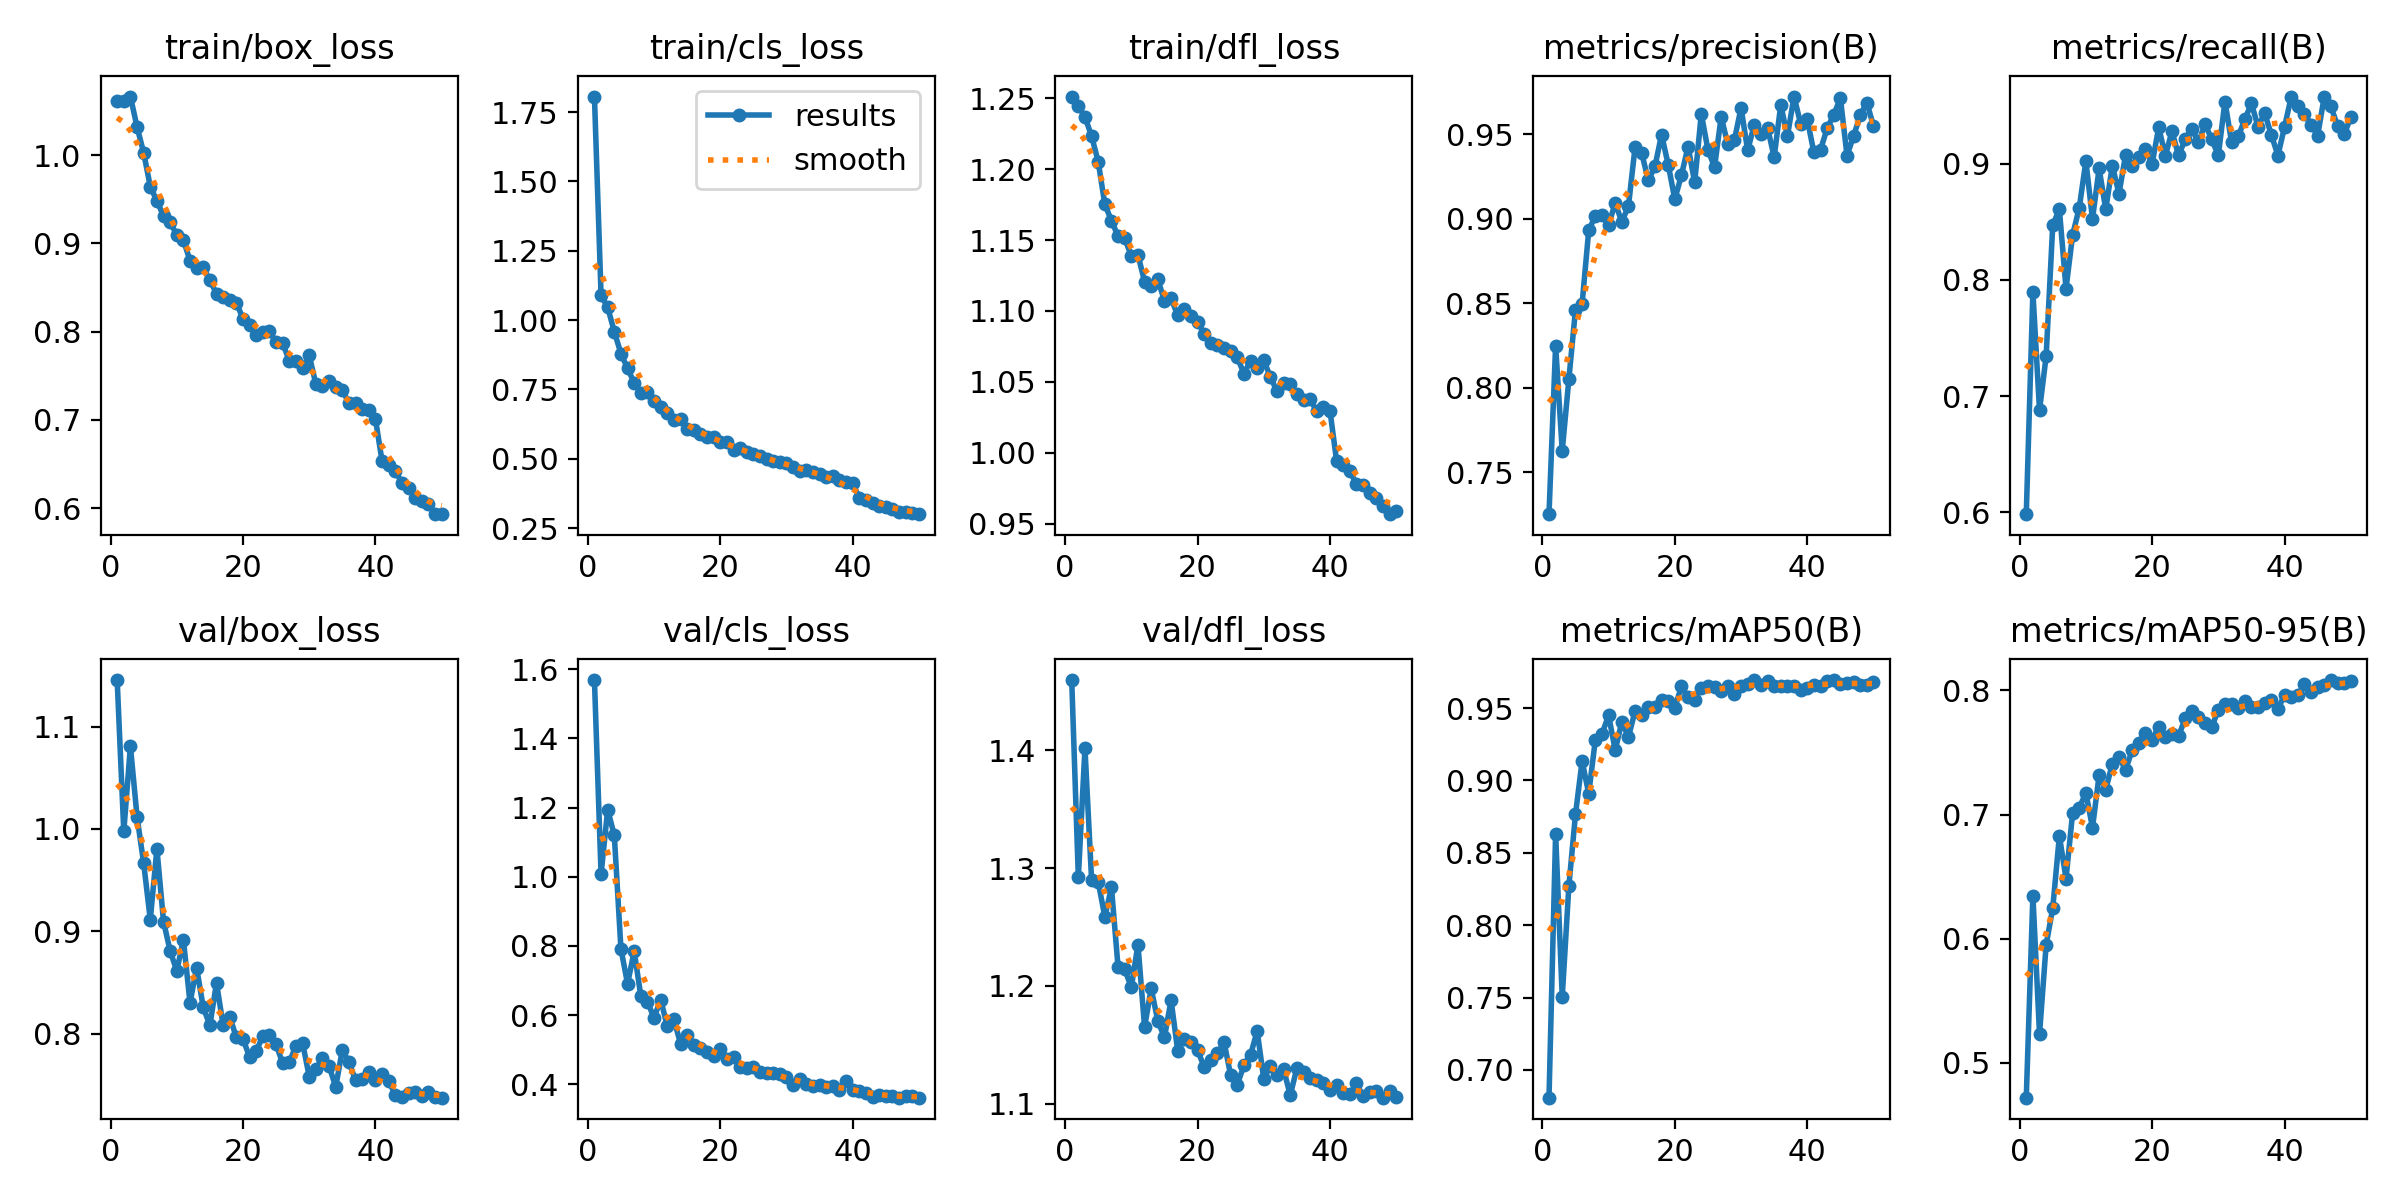

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Show results
display(Image(filename="runs/detect/train/results.png"))


# END